In [ ]:
!pip install torchinfo

In [ ]:
# from google.colab import drive
# drive.mount('https://drive.google.com/drive/folders/1DUp0p23f_V-MW442sVc8e7T2HqphXh1_?usp=drive_link')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import Libraries

In [ ]:
!pip install opencv-python

In [ ]:
!pip install tabulate

In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report

import numpy as np
import cv2

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision import transforms
from torchinfo import summary
import torchvision.models as models

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict

import platform
import psutil

import random
import glob
from tqdm import tqdm
from tqdm.notebook import tqdm

import PIL
from PIL import Image
from torchvision import transforms
from torchvision.transforms import ColorJitter, RandomRotation, RandomResizedCrop
from torchvision.transforms.functional import gaussian_blur
from PIL import ImageOps

import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from PIL import ImageEnhance, ImageOps, ImageFilter
import PIL, PIL.ImageOps, PIL.ImageEnhance, PIL.ImageDraw

from tabulate import tabulate

### Configuration

In [ ]:
cpu_info = platform.processor()

ram_info = psutil.virtual_memory()
total_ram_gb = ram_info.total / (1024 ** 3)

try:
    gpu_info = !nvidia-smi --query-gpu=gpu_name --format=csv
    gpu_name = gpu_info[1]
except:
    gpu_name = "No GPU available"

print("CPU:", cpu_info)
print("Total RAM (GB):", round(total_ram_gb, 2))
print("GPU:", gpu_name)

CPU: x86_64
Total RAM (GB): 12.67
GPU: Tesla T4


### Seed Value

In [ ]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

### Dataset

In [ ]:
root_dir = "/content/drive/MyDrive/Betel/betel_leaf_rezised_dataset"

file_paths = []
labels = []

for class_name in os.listdir(root_dir):
    class_dir = os.path.join(root_dir, class_name)
    for image_name in os.listdir(class_dir):
        file_paths.append(os.path.join(class_dir, image_name))
        labels.append(class_name)

df = pd.DataFrame({"file_path": file_paths, "label": labels})
df = df.sample(frac=1).reset_index(drop=True)

Class: Bacterial Leaf Disease, Count: 250
Class: Fungal Brown Spot Disease, Count: 250
Class: Healthy Leaf, Count: 231
Class: Dried Leaf, Count: 109


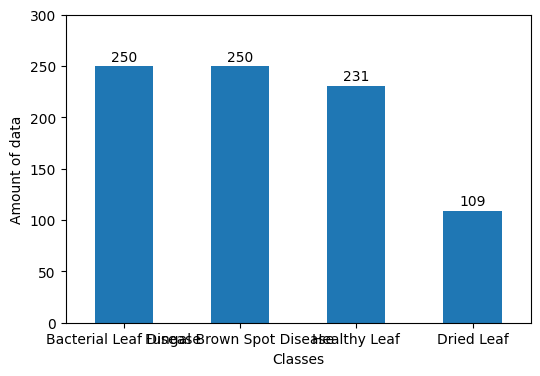

In [ ]:
class_counts_df = df['label'].value_counts()

for class_name, count in class_counts_df.items():
    print(f"Class: {class_name}, Count: {count}")

plt.figure(figsize=(6, 4))
ax = class_counts_df.plot(kind='bar')
plt.xlabel('Classes')
plt.ylabel('Amount of data')
plt.xticks(rotation=360)
for i, count in enumerate(class_counts_df):
    ax.text(i, count + 5, str(count), ha='center')
plt.ylim(0, max(class_counts_df) * 1.2)
plt.show()

### Sample Image

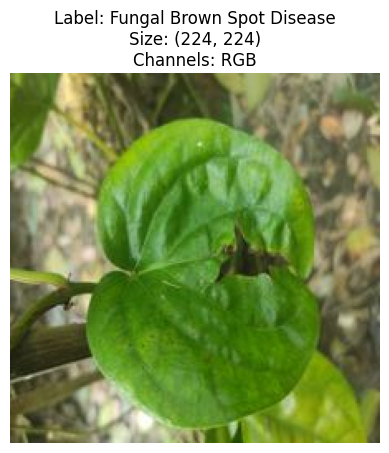

In [ ]:
random_index = random.randint(1, len(df) - 1)
random_row = df.iloc[random_index]

file_path = random_row['file_path']
label = random_row['label']

image = Image.open(file_path)

size = image.size
channels = 'Grayscale' if image.mode == 'L' else 'RGB'
plt.title(f"Label: {label}\nSize: {size}\nChannels: {channels}")
plt.imshow(image)
plt.axis('off')
plt.show()

### Dataset Splits

In [ ]:
train_dataframe, test_dataframe = train_test_split(df, test_size=0.2, random_state=42)
test_dataframe, valid_dataframe = train_test_split(test_dataframe, test_size=0.5, random_state=42)
ulb_dataframe, lb_dataframe = train_test_split(train_dataframe, test_size=0.50, random_state=42)

In [ ]:
print("Unlabeled Data: ", len(ulb_dataframe))
print("Labeled Data: ", len(lb_dataframe))
print("Validation Data: ", len(valid_dataframe))
print("Test Data: ", len(test_dataframe))
print("-------------------------------------------")
print("Total amounts of data in the dataset: ", len(df))

Unlabeled Data:  336
Labeled Data:  336
Validation Data:  84
Test Data:  84
-------------------------------------------
Total amounts of data in the dataset:  840


In [ ]:
class_counts_lb = lb_dataframe['label'].value_counts()
class_counts_ulb = ulb_dataframe['label'].value_counts()
class_counts_valid = valid_dataframe['label'].value_counts()
class_counts_test = test_dataframe['label'].value_counts()

lb_table_data = [[class_name, count] for class_name, count in class_counts_lb.items()]
ulb_table_data = [[class_name, count] for class_name, count in class_counts_ulb.items()]
valid_table_data = [[class_name, count] for class_name, count in class_counts_valid.items()]
test_table_data = [[class_name, count] for class_name, count in class_counts_test.items()]

print("Labeled Dataset")
print(tabulate(lb_table_data, headers=["Class", "Count"]))
print("\nUnlabeled Dataset")
print(tabulate(ulb_table_data, headers=["Class", "Count"]))
print("\nValidation Dataset")
print(tabulate(valid_table_data, headers=["Class", "Count"]))
print("\nTest Dataset")
print(tabulate(test_table_data, headers=["Class", "Count"]))

Labeled Dataset
Class                        Count
-------------------------  -------
Bacterial Leaf Disease         108
Fungal Brown Spot Disease       98
Healthy Leaf                    93
Dried Leaf                      37

Unlabeled Dataset
Class                        Count
-------------------------  -------
Fungal Brown Spot Disease       99
Bacterial Leaf Disease          97
Healthy Leaf                    86
Dried Leaf                      54

Validation Dataset
Class                        Count
-------------------------  -------
Fungal Brown Spot Disease       32
Healthy Leaf                    24
Bacterial Leaf Disease          21
Dried Leaf                       7

Test Dataset
Class                        Count
-------------------------  -------
Healthy Leaf                    28
Bacterial Leaf Disease          24
Fungal Brown Spot Disease       21
Dried Leaf                      11


### Device

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Variables

In [ ]:
total_class = 4
threshold_value = 0.75

### Batch Sizes

In [ ]:
mu = 4
lb_batch = 8
ulb_batch = mu*lb_batch
val_batch = 8
print("Batch Size of Labeled Data: ", lb_batch)
print("Batch Size of Unlabeled Data: ", lb_batch,"x",mu, " = ", ulb_batch)
print("Batch Size of Validation Data: ", val_batch)

Batch Size of Labeled Data:  8
Batch Size of Unlabeled Data:  8 x 4  =  32
Batch Size of Validation Data:  8


### Checkpoint

In [ ]:
save_path_checkpoints = "/content/drive/MyDrive/Colab Notebooks/checkpoint"
os.makedirs(save_path_checkpoints, exist_ok=True)

### Dataset Class, Dataloader and Augmentations

In [ ]:
class ImageDatasetWithAugmentation(Dataset):
    def __init__(self, dataframe, weak_transform, strong_transform, normalize, is_lb=False):
        self.dataframe = dataframe
        self.weak_transform = weak_transform
        self.strong_transform = strong_transform
        self.normalize = normalize
        self.is_lb = is_lb
        self.label_map = {'Bacterial Leaf Disease': 0, 'Dried Leaf': 1, 'Fungal Brown Spot Disease': 2, 'Healthy Leaf': 3}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_path = self.dataframe.iloc[index]['file_path']
        image = PIL.Image.open(img_path)

        if self.is_lb:
            label = self.label_map[self.dataframe.iloc[index]['label']]
            return self.normalize(self.weak_transform(image)), label
        else:
            weak_image = self.weak_transform(image)
            strong_image = self.strong_transform(image)
            return self.normalize(weak_image), self.normalize(strong_image)

In [ ]:
class ImageDatasetNoAugmentation(Dataset):
    def __init__(self, dataframe, normalize, is_lb=False):
        self.dataframe = dataframe
        self.normalize = normalize
        self.is_lb = is_lb
        self.label_map = {'Bacterial Leaf Disease': 0, 'Dried Leaf': 1, 'Fungal Brown Spot Disease': 2, 'Healthy Leaf': 3}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_path = self.dataframe.iloc[index]['file_path']
        image = PIL.Image.open(img_path)

        if self.is_lb:
            label = self.label_map[self.dataframe.iloc[index]['label']]
            return self.normalize(image), label
        else:
            return self.normalize(image), self.normalize(image)

In [ ]:
import torch
import random
import numpy as np
from PIL import Image, ImageOps, ImageEnhance, ImageDraw, ImageFilter
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd # Import pandas

# Your custom dataset
class ImageDatasetWithAugmentation(Dataset):
    def __init__(self, dataframe, weak_transform, strong_transform, normalize, is_lb=True):
        self.dataframe = dataframe.reset_index(drop=True)
        self.weak_transform = weak_transform
        self.strong_transform = strong_transform
        self.normalize = normalize
        self.is_lb = is_lb
        # Add label_map here if it's needed in __getitem__ for labeled data
        self.label_map = {'Bacterial Leaf Disease': 0, 'Dried Leaf': 1, 'Fungal Brown Spot Disease': 2, 'Healthy Leaf': 3}


    def __getitem__(self, index):
        # Access the file path using the correct column name 'file_path'
        path = self.dataframe.iloc[index]['file_path']
        image = Image.open(path).convert('RGB')

        if self.is_lb:
            # Access the label using the correct column name 'label' and map it to an integer
            label = self.label_map[self.dataframe.iloc[index]['label']]
            image = self.weak_transform(image)
            image = self.normalize(image)
            return image, label
        else:
            weak_img = self.weak_transform(image)
            strong_img = self.strong_transform(image)
            return self.normalize(weak_img), self.normalize(strong_img)

    def __len__(self):
        return len(self.dataframe)

# Augmentation functions (rest of the code remains the same)
def augment_list():
    def ShearX(img, v): return img.transform(img.size, Image.AFFINE, (1, v if random.random() > 0.5 else -v, 0, 0, 1, 0))
    def ShearY(img, v): return img.transform(img.size, Image.AFFINE, (1, 0, 0, v if random.random() > 0.5 else -v, 1, 0))
    def TranslateX(img, v): return img.transform(img.size, Image.AFFINE, (1, 0, v * img.size[0], 0, 1, 0))
    def TranslateY(img, v): return img.transform(img.size, Image.AFFINE, (1, 0, 0, 0, 1, v * img.size[1]))
    def Rotate(img, v): return img.rotate(v if random.random() > 0.5 else -v)
    def AutoContrast(img, _): return ImageOps.autocontrast(img)
    def Invert(img, _): return ImageOps.invert(img)
    def Equalize(img, _): return ImageOps.equalize(img)
    def Solarize(img, v): return ImageOps.solarize(img, int(v))
    def Posterize(img, v): return ImageOps.posterize(img, max(1, int(v)))
    def Contrast(img, v): return ImageEnhance.Contrast(img).enhance(v)
    def Color(img, v): return ImageEnhance.Color(img).enhance(v)
    def Brightness(img, v): return ImageEnhance.Brightness(img).enhance(v)
    def Sharpness(img, v): return ImageEnhance.Sharpness(img).enhance(v)
    def Cutout(img, v):
        w, h = img.size
        x0 = int(np.random.uniform(w))
        y0 = int(np.random.uniform(h))
        x1 = int(np.clip(x0 + v * w, 0, w))
        y1 = int(np.clip(y0 + v * h, 0, h))
        img_copy = img.copy()
        ImageDraw.Draw(img_copy).rectangle((x0, y0, x1, y1), fill=(127, 127, 127))
        return img_copy
    def Identity(img, _): return img
    def FlipLR(img, _): return img.transpose(Image.FLIP_LEFT_RIGHT)
    def FlipTB(img, _): return img.transpose(Image.FLIP_TOP_BOTTOM)
    def Grayscale(img, _): return ImageOps.grayscale(img).convert("RGB")
    def Blur(img, v): return img.filter(ImageFilter.GaussianBlur(radius=v))
    def Zoom(img, v):
        w, h = img.size
        new_w, new_h = int(w * (1 - v)), int(h * (1 - v))
        img_cropped = img.crop(((w - new_w) // 2, (h - new_h) // 2, (w + new_w) // 2, (h + new_h) // 2))
        return img_cropped.resize((w, h), Image.BICUBIC)

    return [
        (AutoContrast, 0, 1), (Equalize, 0, 1), (Invert, 0, 1), (Rotate, 0, 30),
        (Posterize, 4, 8), (Solarize, 0, 256), (Color, 0.1, 1.9), (Contrast, 0.1, 1.9),
        (Brightness, 0.1, 1.9), (Sharpness, 0.1, 1.9), (ShearX, 0.0, 0.3), (ShearY, 0.0, 0.3),
        (Cutout, 0.0, 0.3), (TranslateX, 0.0, 0.45), (TranslateY, 0.0, 0.45), (FlipLR, 0, 1),
        (FlipTB, 0, 1), (Grayscale, 0, 1), (Blur, 0.1, 2.0), (Zoom, 0.1, 0.3), (Identity, 0, 1)
    ]

# RandAugment class
class RandAugment:
    def __init__(self, n, m):
        self.n = n
        self.m = m
        self.augment_list = augment_list()

    def __call__(self, img):
        ops = random.choices(self.augment_list, k=self.n)
        for op, minval, maxval in ops:
            val = (float(self.m) / 30) * (maxval - minval) + minval
            img = op(img, val)
        return img

# Final data transform
def train_data_transform(lb_dataframe, ulb_dataframe, lb_batch, ulb_batch):
    strong_transform = transforms.Compose([RandAugment(n=4, m=10)])
    weak_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomAffine(degrees=0, translate=(0.125, 0.125)),
    ])
    normalize = transforms.Compose([transforms.ToTensor()])

    ulb_dataset = ImageDatasetWithAugmentation(ulb_dataframe, weak_transform, strong_transform, normalize, is_lb=False)
    lb_dataset = ImageDatasetWithAugmentation(lb_dataframe, weak_transform, strong_transform, normalize, is_lb=True)

    dataloader_ulb_dataset = DataLoader(ulb_dataset, batch_size=ulb_batch, shuffle=True, num_workers=2)
    dataloader_lb_dataset = DataLoader(lb_dataset, batch_size=lb_batch, shuffle=True, num_workers=2)

    return dataloader_ulb_dataset, dataloader_lb_dataset


dataloader_ulb_dataset, dataloader_lb_dataset = train_data_transform(lb_dataframe, ulb_dataframe, lb_batch=lb_batch, ulb_batch=ulb_batch)

In [ ]:
# Final data transform
def train_data_transform(lb_dataframe, ulb_dataframe, lb_batch, ulb_batch):
    strong_transform = transforms.Compose([RandAugment(n=4, m=10)])
    weak_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomAffine(degrees=0, translate=(0.125, 0.125)),
    ])
    normalize = transforms.Compose([transforms.ToTensor()])

    ulb_dataset = ImageDatasetWithAugmentation(ulb_dataframe, weak_transform, strong_transform, normalize, is_lb=False)
    lb_dataset = ImageDatasetWithAugmentation(lb_dataframe, weak_transform, strong_transform, normalize, is_lb=True)

    dataloader_ulb_dataset = DataLoader(ulb_dataset, batch_size=ulb_batch, shuffle=True, num_workers=2)
    dataloader_lb_dataset = DataLoader(lb_dataset, batch_size=lb_batch, shuffle=True, num_workers=2)

    return dataloader_ulb_dataset, dataloader_lb_dataset

# Example usage (replace with your actual values)
# dataloader_ulb_dataset, dataloader_lb_dataset = train_data_transform(lb_dataframe, ulb_dataframe, lb_batch=32, ulb_batch=128)

# Call the function to create the dataloaders
dataloader_ulb_dataset, dataloader_lb_dataset = train_data_transform(lb_dataframe, ulb_dataframe, lb_batch=lb_batch, ulb_batch=ulb_batch)

# %%
def valid_data_transfrom():

    normalize = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor()])

    valid_dataset = ImageDatasetNoAugmentation(
        valid_dataframe,
        normalize,
        is_lb=True
    )

    test_dataset = ImageDatasetNoAugmentation(
        test_dataframe,
        normalize,
        is_lb=True
    )

    dataloader_valid_dataset = DataLoader(valid_dataset, batch_size = val_batch, shuffle=False, num_workers=2)
    dataloader_test_dataset = DataLoader(test_dataset, batch_size = val_batch, shuffle=False, num_workers=2)

    return dataloader_valid_dataset, dataloader_test_dataset

dataloader_valid_dataset, dataloader_test_dataset = valid_data_transfrom()

### Neural Network

In [ ]:
learning_rate = 0.0001

model = models.densenet201(weights=models.DenseNet201_Weights.DEFAULT)


# Replace the classifier
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, total_class)
model = model.to(device)

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0005)

summary(model, input_size=(lb_batch, 3, 224, 224))

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 99.3MB/s]


Layer (type:depth-idx)                   Output Shape              Param #
DenseNet                                 [8, 4]                    --
├─Sequential: 1-1                        [8, 1920, 7, 7]           --
│    └─Conv2d: 2-1                       [8, 64, 112, 112]         9,408
│    └─BatchNorm2d: 2-2                  [8, 64, 112, 112]         128
│    └─ReLU: 2-3                         [8, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                    [8, 64, 56, 56]           --
│    └─_DenseBlock: 2-5                  [8, 256, 56, 56]          --
│    │    └─_DenseLayer: 3-1             [8, 32, 56, 56]           45,440
│    │    └─_DenseLayer: 3-2             [8, 32, 56, 56]           49,600
│    │    └─_DenseLayer: 3-3             [8, 32, 56, 56]           53,760
│    │    └─_DenseLayer: 3-4             [8, 32, 56, 56]           57,920
│    │    └─_DenseLayer: 3-5             [8, 32, 56, 56]           62,080
│    │    └─_DenseLayer: 3-6             [8, 32, 56, 56]     

# FixMatch Training

##### FixMatch Implementation

In [ ]:
def train_fixMatch(model, optimizer, dataloader_lb_dataset, dataloader_ulb_dataset, device, threshold):
    model.train()

    losses = []
    correct_predictions = 0
    total_samples = 0

    pbar = tqdm(dataloader_lb_dataset)

    ulb_iter = iter(dataloader_ulb_dataset)

    for batch_lb in pbar:
        model.zero_grad()

        # labelled data
        x_lb, y = batch_lb
        x_lb, y = x_lb.to(device), y.to(device)

        # unlabelled data
        try:
            x_weak, x_strong = next(ulb_iter)
        except StopIteration:
            ulb_iter = iter(dataloader_ulb_dataset)
            x_weak, x_strong = next(ulb_iter)

        x_weak, x_strong = x_weak.to(device), x_strong.to(device)

        # concat all x
        all_x = torch.cat([x_lb, x_weak, x_strong], dim=0)

        # compute logits
        all_logits = model(all_x)

        # logits and loss for labelled data
        logits_lb = all_logits[:x_lb.size(0)]
        loss_lb = F.cross_entropy(logits_lb, y)

        # logits for unlabelled data
        logits_ulb = all_logits[x_lb.size(0):]
        logits_weak, logits_strong = torch.chunk(logits_ulb, 2, dim=0)

        # stop gradient for weak augmented
        logits_weak = logits_weak.detach()

        # compute class probabilities
        probs_weak = F.softmax(logits_weak, dim=1)

        # compute pseudo labels (torch.max outputs the maximum values and the argmax)
        max_prob, pseudo_label = torch.max(probs_weak, dim=1)

        # mask for confident predictions
        mask = (max_prob > threshold).float()

        # mask non-confident prediction
        pseudo_label = pseudo_label.masked_fill(mask == 0, 0)

        # unsupervised loss by ignoring non-confident prediction
        loss_ulb = F.cross_entropy(logits_strong, pseudo_label, ignore_index=-1)

        # total loss
        loss = loss_lb + loss_ulb

        # compute accuracy for labeled data
        _, predicted = torch.max(logits_lb, 1)
        correct_predictions += (predicted == y).sum().item()
        total_samples += y.size(0)

        loss.backward()
        optimizer.step()

        loss_item = loss.item()
        losses.append(loss_item)

        pbar.set_description(f'train loss = {np.array(losses).mean():.3f}, accuracy = {correct_predictions / total_samples:.3f}')

        fig, axes = plt.subplots(1, 10, figsize=(6, 4))
        for i, ax in enumerate(axes.flat):
            ax.imshow(x_strong[i].cpu().permute(1, 2, 0))
            ax.axis('off')
            # ax.set_title(f'Label: {y[i].item()}')
        plt.show()

    return np.array(losses).mean(), correct_predictions / total_samples

##### Validation

In [ ]:
def validate(model, dataloader, device):
    model.eval()
    correct_predictions = 0
    total_samples = 0
    val_losses = []

    with torch.no_grad():
        for batch in dataloader:
            x_val, y_val = batch
            x_val, y_val = x_val.to(device), y_val.to(device)

            logits_val = model(x_val)
            loss_val = F.cross_entropy(logits_val, y_val)

            _, predicted_val = torch.max(logits_val, 1)
            correct_predictions += (predicted_val == y_val).sum().item()
            total_samples += y_val.size(0)

            val_losses.append(loss_val.item())

    accuracy = correct_predictions / total_samples
    val_loss = np.array(val_losses).mean()

    return accuracy, val_loss

##### Training

In [ ]:
import time
start_time = time.time()

num_epochs = 25
early_stopping_rounds = 5
total_iterations = 0

num_epochs_without_improvement = 0
num_epochs_loss_greater = 0

losses = []
accuracies = []
val_losses = []
val_accuracies = []
best_val_accuracy = 0
prev_val_loss = float('inf')

for epoch in range(num_epochs):
    train_loss, train_accuracy = train_fixMatch(model, optimizer, dataloader_lb_dataset, dataloader_ulb_dataset, device, threshold=threshold_value)
    val_accuracy, val_loss = validate(model, dataloader_valid_dataset, device)

    losses.append(train_loss)
    accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch + 1}/{num_epochs} - '
          f'Train Loss: {train_loss:.3f}, Train Accuracy: {train_accuracy:.3f} - '
          f'Validation Loss: {val_loss:.3f}, Validation Accuracy: {val_accuracy:.3f}')

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_epoch = epoch + 1
        filepath = f"{save_path_checkpoints}/model.pt"
        checkpoint = {
            "epoch": epoch + 1,
            "model_weight": model.state_dict(),
            "optimizer_state": optimizer.state_dict()
        }
        torch.save(checkpoint, filepath)
        print(f"Best model saved at epoch {best_epoch} with validation accuracy: {best_val_accuracy:.3f}")
        num_epochs_without_improvement = 0
    else:
        num_epochs_without_improvement += 1

    if val_loss > train_loss:
        num_epochs_loss_greater += 1
    else:
        num_epochs_loss_greater = 0

    if num_epochs_without_improvement >= early_stopping_rounds or num_epochs_loss_greater >= early_stopping_rounds:
        print(f"Early stopping criteria met. No improvement in validation accuracy or validation loss for {early_stopping_rounds} consecutive epochs. Training stopped.")
        break

print("Training complete.........")

end_time = time.time()
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")
print("Training Time:", training_time/60, "minitues")

In [ ]:
print(losses)
print()
print(accuracies)
print()
print(val_losses)
print()
print(val_accuracies)

[np.float64(1.8702954252560933), np.float64(1.2605697782266707), np.float64(0.9391623295488811), np.float64(0.8402023102555957), np.float64(0.9228585206326985), np.float64(0.923920621474584), np.float64(0.9038742468470619), np.float64(0.7738632552680516), np.float64(0.6698413682835442), np.float64(0.6351025111618496), np.float64(0.5542502942539397), np.float64(0.5041976862010502), np.float64(0.47691393537180765), np.float64(0.4165094342260134), np.float64(0.41590751778511775), np.float64(0.36434381774493624), np.float64(0.3429610147362664), np.float64(0.3538257412257649), np.float64(0.29243861245257513), np.float64(0.2809248357301667), np.float64(0.2800763545646554), np.float64(0.2891404000776155), np.float64(0.23766194816146577), np.float64(0.2607367288853441), np.float64(0.23675700312569029)]

[0.3125, 0.44047619047619047, 0.6755952380952381, 0.8363095238095238, 0.9285714285714286, 0.9464285714285714, 0.9464285714285714, 0.9523809523809523, 0.9672619047619048, 0.9583333333333334, 0.9

##### Plots

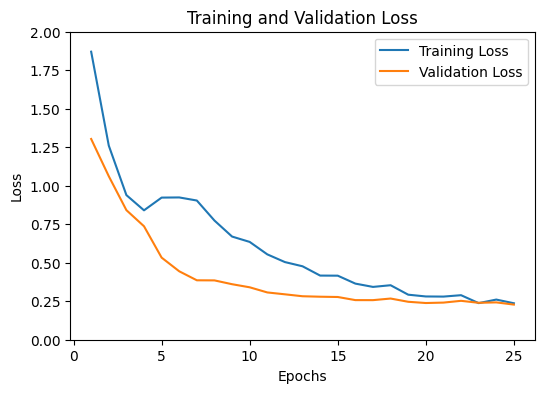

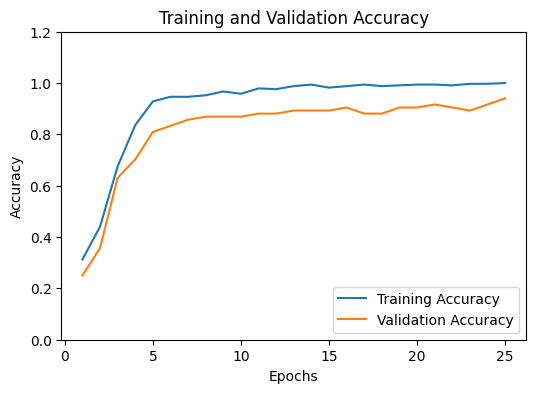

In [ ]:
epochs = range(1, len(losses)+1)

plt.figure(figsize=(6, 4))
plt.plot(epochs, losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.ylim(0,2)
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(epochs, accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.ylim(0,1.2)
plt.show()

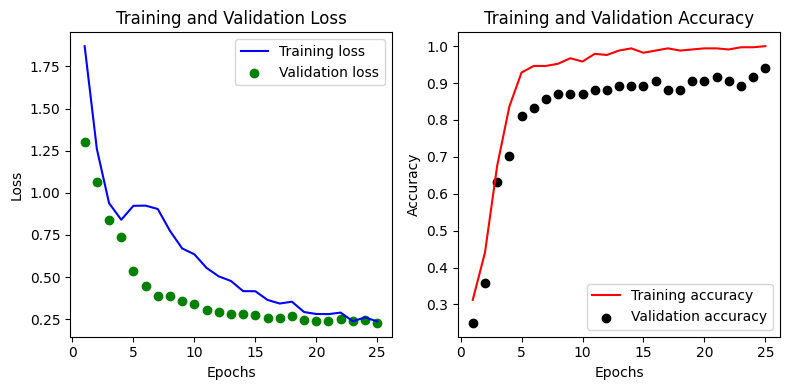

In [ ]:
epochs = range(1, len(losses) + 1)

plt.figure(figsize=(8, 4))

# Plotting losses
plt.subplot(1, 2, 1)
plt.plot(epochs, losses, 'blue', label='Training loss')
plt.scatter(epochs, val_losses, color='green', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting accuracies
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies, 'red', label='Training accuracy')
plt.scatter(epochs, val_accuracies, color='black', label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### FixMatch Model Evaluation

In [ ]:
best_checkpoint_path = f"{save_path_checkpoints}/model.pt"
checkpoint = torch.load(best_checkpoint_path)
best_epoch = checkpoint["epoch"]
model.load_state_dict(checkpoint["model_weight"])
optimizer.load_state_dict(checkpoint["optimizer_state"])

best_val_accuracy, best_val_loss = validate(model, dataloader_valid_dataset, device)
print(f"Best model (from epoch {best_epoch}) - Validation Loss: {best_val_loss:.3f}, Validation Accuracy: {best_val_accuracy:.3f}")

test_accuracy, test_loss = validate(model, dataloader_test_dataset, device)
print(f"Test Accuracy: {test_accuracy:.3f}")

Best model (from epoch 25) - Validation Loss: 0.228, Validation Accuracy: 0.940
Test Accuracy: 0.988


In [ ]:
def get_predictions_labels(model, dataloader, device):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            x, y = batch
            x, y = x.to(device), y.to(device)

            logits = model(x)
            predictions = torch.argmax(logits, dim=1).cpu().numpy()

            all_predictions.extend(predictions)
            all_labels.extend(y.cpu().numpy())

    return all_predictions, all_labels

test_predictions, test_labels = get_predictions_labels(model, dataloader_test_dataset, device)

class_names = [str(i) for i in range(total_class)]
val_classification_report = classification_report(test_labels, test_predictions, target_names=class_names)

print("Classification Report:")
print(val_classification_report)

def class_accuracy(predictions, labels, num_classes):
    class_correct = [0] * num_classes
    class_total = [0] * num_classes

    for pred, label in zip(predictions, labels):
        class_correct[label] += (pred == label)
        class_total[label] += 1

    class_acc = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]
    return class_acc

class_acc = class_accuracy(test_predictions, test_labels, total_class)

for i, acc in enumerate(class_acc):
    print(f"Class {i}: Accuracy = {acc:.3f}")

print()
print("'Bacterial Leaf': 0, 'Dried Leaf': 1, 'Fungal Brown Spot': 2, 'Fungal Brown Spot': 3")

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        24
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00        21
           3       1.00      0.96      0.98        28

    accuracy                           0.99        84
   macro avg       0.99      0.99      0.99        84
weighted avg       0.99      0.99      0.99        84

Class 0: Accuracy = 1.000
Class 1: Accuracy = 1.000
Class 2: Accuracy = 1.000
Class 3: Accuracy = 0.964

'Bacterial Leaf': 0, 'Dried Leaf': 1, 'Fungal Brown Spot': 2, 'Fungal Brown Spot': 3


In [ ]:
def print_augmentations():
    augmentations = [
        "AutoContrast",
        "Equalize",
        "Invert",
        "Rotate",
        "Posterize",
        "Solarize",
        "Color",
        "Contrast",
        "Brightness",
        "Sharpness",
        "ShearX",
        "ShearY",
        "Cutout",
        "TranslateX",
        "TranslateY",
        "Identity"
    ]
    for i, aug in enumerate(augmentations, 1):
        print(f"{i}. {aug}")

print_augmentations()


1. AutoContrast
2. Equalize
3. Invert
4. Rotate
5. Posterize
6. Solarize
7. Color
8. Contrast
9. Brightness
10. Sharpness
11. ShearX
12. ShearY
13. Cutout
14. TranslateX
15. TranslateY
16. Identity


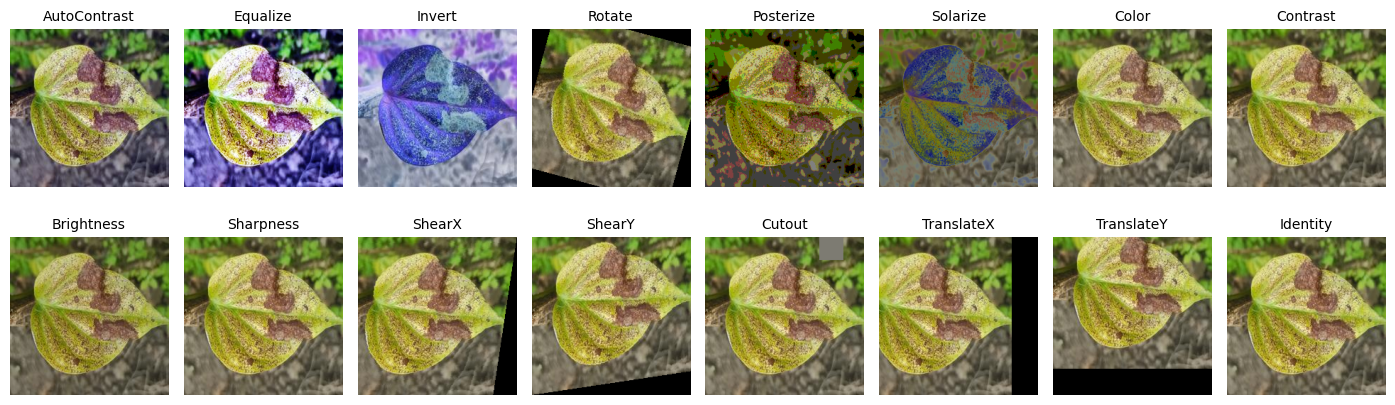

In [ ]:
import PIL
from PIL import Image, ImageOps, ImageEnhance, ImageDraw
import matplotlib.pyplot as plt
import numpy as np
import random

# Your augmentation functions (copied and adapted):

def AutoContrast(img, _):
    return ImageOps.autocontrast(img)

def Equalize(img, _):
    return ImageOps.equalize(img)

def Invert(img, _):
    return ImageOps.invert(img)

def Rotate(img, v):  # [-30, 30]
    if random.random() > 0.5:
        v = -v
    return img.rotate(v)

def Posterize(img, v):  # [4, 8]
    v = int(max(1, v))
    return ImageOps.posterize(img, v)

def Solarize(img, v):  # [0, 256]
    inverted_v = 256 - v
    return ImageOps.solarize(img, inverted_v)

def Color(img, v):  # [0.1, 1.9]
    v = 1.9 - v
    return ImageEnhance.Color(img).enhance(v)

def Contrast(img, v):  # [0.1, 1.9]
    enhanced_v = 1.9 - v + 0.1
    return ImageEnhance.Contrast(img).enhance(enhanced_v)

def Brightness(img, v):  # [0.1, 1.9]
    v = 1.9 - v
    return ImageEnhance.Brightness(img).enhance(v)

def Sharpness(img, v):  # [0.1, 1.9]
    return ImageEnhance.Sharpness(img).enhance(v)

def ShearX(img, v):  # [-0.3, 0.3]
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, v, 0, 0, 1, 0))

def ShearY(img, v):  # [-0.3, 0.3]
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, v, 1, 0))

def CutoutAbs(img, v):
    if v < 0:
        return img
    w, h = img.size
    x0 = np.random.uniform(w)
    y0 = np.random.uniform(h)
    x0 = int(max(0, x0 - v / 2.))
    y0 = int(max(0, y0 - v / 2.))
    x1 = min(w, x0 + v)
    y1 = min(h, y0 + v)
    xy = (x0, y0, x1, y1)
    color = (125, 123, 114)
    img = img.copy()
    ImageDraw.Draw(img).rectangle(xy, color)
    return img

def Cutout(img, v):  # [0, 0.3] percentage of width
    if v <= 0.:
        return img
    v = v * img.size[0]
    return CutoutAbs(img, v)

def TranslateX(img, v):  # [-0.45, 0.45]
    if random.random() > 0.5:
        v = -v
    v = v * img.size[0]
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0))

def TranslateY(img, v):  # [-0.45, 0.45]
    if random.random() > 0.5:
        v = -v
    v = v * img.size[1]
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v))

def Identity(img, v):
    return img

def augment_list():
    return [
        (AutoContrast, 0, 1),
        (Equalize, 0, 1),
        (Invert, 0, 1),
        (Rotate, 0, 30),
        (Posterize, 0, 4),
        (Solarize, 0, 256),
        (Color, 0.1, 1.9),
        (Contrast, 0.1, 1.9),
        (Brightness, 0.1, 1.9),
        (Sharpness, 0.1, 1.9),
        (ShearX, 0.0, 0.3),
        (ShearY, 0.0, 0.3),
        (Cutout, 0, 0.3),
        (TranslateX, 0.0, 0.33),
        (TranslateY, 0.0, 0.33),
        (Identity, 0, 1)
    ]
def visualize_augmentations(img):
    aug_list = augment_list()

    # Adjust figure size and layout for compact spacing
    fig, axs = plt.subplots(2, 8, figsize=(14, 4))  # Slightly narrower width
    axs = axs.flatten()

    for i, (op, minval, maxval) in enumerate(aug_list):
        val = (minval + maxval) / 2
        augmented_img = op(img, val)
        axs[i].imshow(np.array(augmented_img))
        axs[i].set_title(op.__name__, fontsize=10)
        axs[i].axis('off')

    # Reduce gaps between subplots
    plt.tight_layout(pad=0.9)  # Reduce padding between rows and plot area
    plt.subplots_adjust(wspace=0.1, hspace=0.3)  # Reduced column and row spacing

    plt.show()

# Load your image
img_path = '/content/drive/MyDrive/Betel/betel_leaf_rezised_dataset/Fungal Brown Spot Disease/Fungal_Brown_Spot_Disease(123).jpg'
img = Image.open(img_path).convert('RGB')

visualize_augmentations(img)


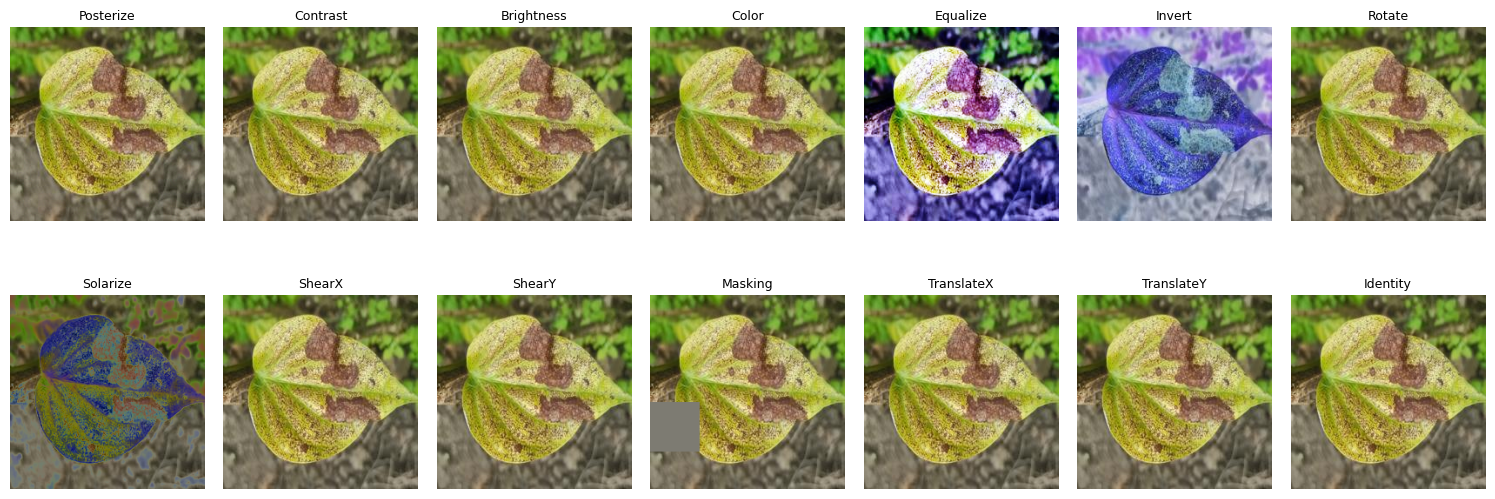

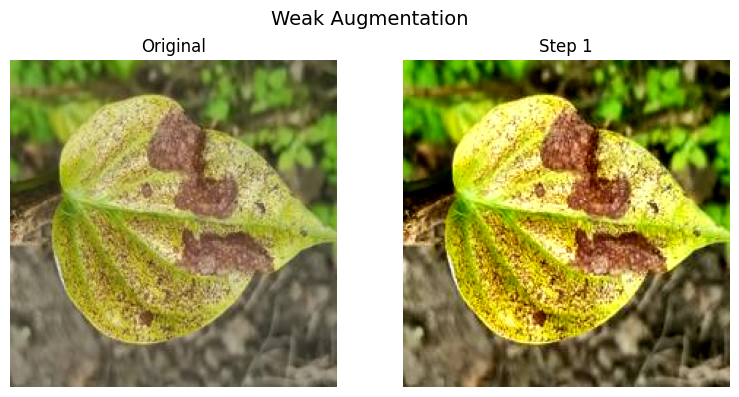

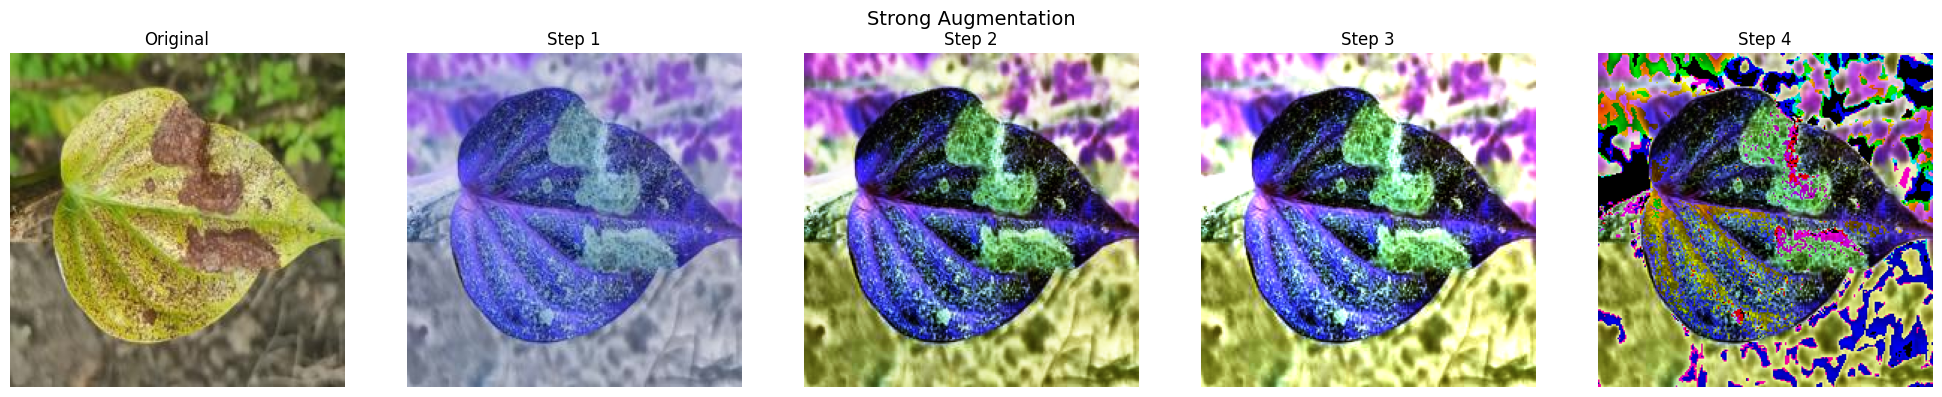

In [ ]:
import random
import matplotlib.pyplot as plt
from PIL import Image, ImageOps, ImageEnhance, ImageDraw
import numpy as np

# All augmentation ops
def Posterize(img, v): return ImageOps.posterize(img, int(v))
def Contrast(img, v): return ImageEnhance.Contrast(img).enhance(v)
def Brightness(img, v): return ImageEnhance.Brightness(img).enhance(v)
def Color(img, v): return ImageEnhance.Color(img).enhance(v)
def Equalize(img, _): return ImageOps.equalize(img)
def Invert(img, _): return ImageOps.invert(img)
def Rotate(img, v): return img.rotate(v)
def Solarize(img, v): return ImageOps.solarize(img, int(v))
def ShearX(img, v): return img.transform(img.size, Image.AFFINE, (1, v, 0, 0, 1, 0))
def ShearY(img, v): return img.transform(img.size, Image.AFFINE, (1, 0, 0, v, 1, 0))
def CutoutAbs(img, v):
    w, h = img.size
    x0 = np.random.uniform(w)
    y0 = np.random.uniform(h)
    x0 = int(max(0, x0 - v / 2))
    y0 = int(max(0, y0 - v / 2))
    x1 = min(w, x0 + v)
    y1 = min(h, y0 + v)
    color = (125, 123, 114)
    img = img.copy()
    ImageDraw.Draw(img).rectangle((x0, y0, x1, y1), color)
    return img
def Masking(img, v): return CutoutAbs(img, int(v * img.size[0]))
def TranslateX(img, v): return img.transform(img.size, Image.AFFINE, (1, 0, int(v * img.size[0]), 0, 1, 0))
def TranslateY(img, v): return img.transform(img.size, Image.AFFINE, (1, 0, 0, 0, 1, int(v * img.size[1])))
def Identity(img, _): return img

# Aug list
def augment_list():
    return [
        (Posterize, 4, 8),
        (Contrast, 0.1, 1.9),
        (Brightness, 0.1, 1.9),
        (Color, 0.1, 1.9),
        (Equalize, 0, 1),
        (Invert, 0, 1),
        (Rotate, -30, 30),
        (Solarize, 0, 256),
        (ShearX, -0.3, 0.3),
        (ShearY, -0.3, 0.3),
        (Masking, 0, 0.5),
        (TranslateX, -0.45, 0.45),
        (TranslateY, -0.45, 0.45),
        (Identity, 0, 1),
    ]

# Visualize all augmentations
def visualize_augmentations(img):
    aug_list_data = augment_list()
    fig, axs = plt.subplots(2, 7, figsize=(15, 5))
    axs = axs.flatten()

    for i, (op, minval, maxval) in enumerate(aug_list_data):
        val = (minval + maxval) / 2
        augmented_img = op(img, val)
        axs[i].imshow(np.array(augmented_img))
        axs[i].set_title(op.__name__, fontsize=9)
        axs[i].axis('off')

    plt.tight_layout(pad=0.9)
    plt.subplots_adjust(wspace=0.1, hspace=0.3)
    plt.show()

# RandAugment
class RandAugment:
    def __init__(self, n_select=4, magnitude=5):
        self.n_select = n_select
        self.magnitude = magnitude
        self.augmentations = [op for op, _, _ in augment_list()]
        self.magnitude_ranges = {op: (minv, maxv) for op, minv, maxv in augment_list()}

    def apply(self, img):
        selected_augs = random.sample(self.augmentations, self.n_select)
        imgs = [img.copy()]
        for aug in selected_augs:
            minval, maxval = self.magnitude_ranges[aug]
            val = random.uniform(minval, maxval)
            img = aug(img, val)
            imgs.append(img.copy())
        return imgs

# Visualize RandAugment steps
def visualize_randaugment(img, n_select, label):
    ra = RandAugment(n_select=n_select)
    imgs = ra.apply(img)

    fig, axs = plt.subplots(1, len(imgs), figsize=(4 * len(imgs), 4))
    for i, ax in enumerate(axs):
        ax.imshow(imgs[i])
        ax.set_title("Original" if i == 0 else f"Step {i}")
        ax.axis('off')
    plt.suptitle(label, fontsize=14)
    plt.tight_layout()
    plt.show()

# Run all visualizations
if __name__ == "__main__":
    img_path = '/content/drive/MyDrive/Betel/betel_leaf_rezised_dataset/Fungal Brown Spot Disease/Fungal_Brown_Spot_Disease(123).jpg'
    img = Image.open(img_path).convert("RGB")

    # 1. Visualize all basic augmentations
    visualize_augmentations(img)

    # 2. Visualize weak augmentation (1 step)
    visualize_randaugment(img, n_select=1, label="Weak Augmentation")

    # 3. Visualize strong augmentation (4 steps)
    visualize_randaugment(img, n_select=4, label="Strong Augmentation")
